In [1]:
from collections import deque, namedtuple
from random import sample
import numpy as np
import gym 
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt 
import optuna

C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
env = gym.make('LunarLander-v2')

C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
num_episodes = 3
for i in range(num_episodes):
    state = env.reset()
    Done = False
    total_rewards = 0
    
    while not Done: 
        #take a random action
        action = env.action_space.sample()
        #implement the action 
        next_state, reward, Done, info = env.step(action)
        #sum the rewards
        total_rewards += reward
        #render the env
        env.render()
    print("The episode total rewards is ", total_rewards)

env.close()

The episode total rewards is  -135.17469718325276
The episode total rewards is  -116.7741200625006
The episode total rewards is  -265.583606382973


In [51]:
state = env.reset()
state

array([-5.8755872e-04,  1.4036485e+00, -5.9532933e-02, -3.2317889e-01,
        6.8766251e-04,  1.3485086e-02,  0.0000000e+00,  0.0000000e+00],
      dtype=float32)

In [2]:
class Deep_Q_Network(nn.Module):
    def __init__(self,num_states,num_actions,nodes_1 =50, nodes_2 = 50):
        super(Deep_Q_Network,self).__init__()
        self.fc1 = nn.Linear(num_states,nodes_1)
        self.fc2 = nn.Linear(nodes_1,nodes_2)
        self.fc3 = nn.Linear(nodes_2,num_actions)
    
    def forward(self,states):
        x = F.relu(self.fc1(states))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Deep_Q_Network(8,4).to(device)
print(device)
states = env.reset()
states = torch.from_numpy(states[np.newaxis,:]).to(device)
model(states).max()

cuda


tensor(0.1358, device='cuda:0', grad_fn=<MaxBackward1>)

In [42]:
# class MemoryReplay:
#     def __init__(self, max_size):
#         self.states = []
#         self.actions = []
#         self.rewards = []
#         self.next_states = []
#         self.Dones = []
#         self.max_size = max_size
#         self.idx = 0
#         self.size = 0

#     def append(self, state,action, reward,next_state,Done):
#         #first in, first out 
#         if self.idx <= self.max_size:
#             self.states.append(state)
#             self.actions.append(action)
#             self.rewards.append(reward)
#             self.next_states.append(next_state)
#             self.Dones.append(Done)
#         else:
#             #overwrite older values 
#             self.states[self.idx] = state
#             self.actions[self.idx]= action
#             self.rewards[self.idx] = reward
#             self.next_states[self.idx] =next_state
#             self.Dones[self.idx] = Done
#         self.size = min(self.size + 1, self.max_size)
#         self.idx = (self.idx + 1) % self.max_size

#     def sample(self, batch_size):
#         indices = sample(range(self.size), batch_size)
#         states = np.array(self.states)[indices]
#         actions =  np.array(self.actions)[indices]
#         rewards = np.array(self.rewards)[indices]
#         next_states = np.array(self.next_states)[indices]
#         Dones = np.array(self.Dones)[indices]
        
#         return states,actions, rewards, next_states, Dones
#     def __len__(self):
#         return self.size

In [7]:
class MemoryReplay:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    
    def append(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self,batch_size):
        """Randomly sample a batch of experiences from memory."""
        experiences = sample(self.memory, k=batch_size)

        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.vstack([e.action for e in experiences if e is not None]).squeeze(1)
        rewards = np.vstack([e.reward for e in experiences if e is not None]).squeeze(1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None])
        dones = np.vstack([e.done for e in experiences if e is not None]).squeeze(1)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## test Memory Replay 

In [10]:
m1 = MemoryReplay(10000)

num_episodes = 150
for i in range(num_episodes):
    state = env.reset()
    Done = False
    total_rewards = 0
    
    while not Done: 
        #take a random action
        action = env.action_space.sample()
        #implement the action 
        next_state, reward, Done, info = env.step(action)
        #sum the rewards
        total_rewards += reward
        m1.append(state,action,reward,next_state,Done)
        state = next_state
    #print("The episode total rewards is ", total_rewards)

len(m1)

10000

In [11]:
# m2 = MemoryReplay_2(10000)

# num_episodes = 150
# for i in range(num_episodes):
#     state = env.reset()
#     Done = False
#     total_rewards = 0
    
#     while not Done: 
#         #take a random action
#         action = env.action_space.sample()
#         #implement the action 
#         next_state, reward, Done, info = env.step(action)
#         #sum the rewards
#         total_rewards += reward
#         m2.append(state,action,reward,next_state,Done)
#         state = next_state
#     #print("The episode total rewards is ", total_rewards)

# len(m2)

In [12]:
# states1,actions1,rewards2,next_states1,Dones1 = m1.sample(32)
# states2,actions2,rewards2,next_states2,Dones2 = m2.sample(32)
# print(Dones1.shape, Dones2.shape)

In [13]:
%timeit m1.sample(64)

342 µs ± 7.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
class DQL_Agent:
    def __init__(self,env,memory_max_size =10_000,dicount= 0.99,lr_optim=1e-3,DQL_node1=50,DQL_node2=50,decay_rate = 0.996):
        self.env = env
        self.num_states = env.observation_space.shape[0]
        self.num_action = env.action_space.n
        self.dicount = dicount
        
        self.eps = 1.0
        self.decay_rate_eps = decay_rate
        self.min_eps = 0.05
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.reply_memory = MemoryReplay(memory_max_size)
        self.Q_action = Deep_Q_Network(self.num_states,self.num_action,DQL_node1,DQL_node2).to(self.device)
        self.Q_target = Deep_Q_Network(self.num_states,self.num_action,DQL_node1,DQL_node2).to(self.device)
        self.Q_target.eval() #will turn off any dropout or batch norm layer 
        #make sure both network has identical weights 
        self.update_target_weights()
        
        self.loss_fucntion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.Q_action.parameters(),lr=lr_optim)
        
        
    def update_target_weights(self):
        self.Q_target.load_state_dict(self.Q_action.state_dict())
    
    def eps_greedy(self,states):
        if np.random.rand()<self.eps:
            return self.env.action_space.sample()
        else:
            #act greedy
            
            #make sure the state are tensor in order to feed it to the network
            if not torch.is_tensor(states):
                states = torch.from_numpy(states[np.newaxis,:]).float().to(self.device)
            with torch.no_grad(): #will disable tracking the gradient --> reduce cpu/memory usage
                action = self.Q_action(states)
            max_action = torch.argmax(action).item()
            return max_action
    
    def decay_eps(self):
        self.eps = np.maximum(self.eps*self.decay_rate_eps,self.min_eps)
    
    def to_tensor(self,states, actions, rewards,next_states,Dones):
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        Dones = torch.from_numpy(Dones).to(self.device)
        return states, actions, rewards, next_states, Dones
    def learnFromExperience(self,miniBatchSize): #hallucinations
        if miniBatchSize <2:
            raise ValueError("batch size must greater than 1")
        #make sure we have enough experiences 
        if len(self.reply_memory) < miniBatchSize:
            return #not enough experience, sounds familiar right?
        #else sample and learn
        states, actions, rewards, next_states, Dones = self.reply_memory.sample(miniBatchSize)
        #convert the result to tensor for model input 
        states, actions, rewards, next_states, Dones = self.to_tensor(states, actions, rewards, next_states, Dones)
        #calculate the current Q estimation 
        Q_estimate = self.Q_action(states)
        #obtain the q value for the actioned used in the experiences 
        Q_estimate_a = Q_estimate.gather(1, actions.view(-1, 1)).squeeze(1)
        
        #calculate the target value using --> rewards + discount* argmax_a Q(next_state, target_network_weight)
        #the max gives both the max values and the indices 
        Q_target = self.Q_target(next_states).max(dim=1).values
        #note that one the state is terminal, we only count the reward, therefore, we need to check if the state is Dones
        #if Done is true, we should not calculate Q for the next states 
        Q_target[Dones] = 0.0 
        #final target calculation
        Q_target = rewards + self.dicount*Q_target
        
        #make sure the grad is zero 
        self.optimizer.zero_grad()

        #calculate the loss 
        loss=self.loss_fucntion(Q_target,Q_estimate_a)
        #calcualte the gradient dL/dw
        loss.backward()
        #optimize using gradient decent
        self.optimizer.step()
        
    def get_max_action(self,states):
        self.Q_action.eval()
        #make sure the state are tensor in order to feed it to the network
        if not torch.is_tensor(states):
            states = torch.from_numpy(states[np.newaxis,:]).to(self.device)
        with torch.no_grad(): #will disable tracking the gradient --> reduce cpu/memory usage
            action = self.Q_target(states)
        max_action = torch.argmax(action).item()
        return max_action
        
        
            
        

In [16]:
#using optuna


def train(trial):
    env = gym.make('LunarLander-v2')
    memory_max_size = 10_000
    DQL_node1 = trial.suggest_int('DQL_nodes 1', 30, 100)
    DQL_node2 = trial.suggest_int('nodes_2', 30, 100)
    dicount = trial.suggest_float('dicount rate', 0.9, 1.0, log=True)
    lr_optim = trial.suggest_float('lr', 5e-4, 1e-3, log=True)
    batch_size = trial.suggest_int('batch size', 32, 64)
    decay_rate = trial.suggest_float('decay', 0.99,0.999, log=True)
    agent = DQL_Agent(env,memory_max_size ,dicount ,lr_optim,DQL_node1,DQL_node2,decay_rate)
    update_freq = 1000
    steps = 0 
    
    num_episodes = 500
    rewards = np.zeros(num_episodes)
    moving_average = []
    for i in range(num_episodes):
        state = agent.env.reset()
        Done = False
        total_rewards = 0
        while not Done: 
            #take an action using the greedy policy
            action = agent.eps_greedy(state)
            #implement the action 
            next_state, reward, Done, info = agent.env.step(action)
            #save the experience in the memory of the agent 
            agent.reply_memory.append(state,action,reward,next_state,Done)
            #sum the rewards
            total_rewards += reward

            #learn from experience (if there is enough)
            agent.learnFromExperience(batch_size)
            #update the tarqet network per the desired frequency 
            steps +=1 
            if (steps % update_freq) == 0:
                agent.update_target_weights()
            state = next_state
        #append the rewards
        rewards[i] = total_rewards
        moving_average.append(np.mean(rewards[-50:]))
        #update the eps 
        agent.decay_eps()
        if i %10 == 0:
            print("The episode {} total rewards is {}".format(i+1, total_rewards))
            #print(len(agent.reply_memory))
        
    #testing 
    num_tests = 20
    rewards_testing = np.zeros(num_tests)
    for i in range(num_tests):
        state = env.reset()
        Done = False 
        total_rewards = 0
        while not Done: 
            action = agent.get_max_action(state)
            next_state, reward,Done, info = env.step(action)
            total_rewards += reward
            state = next_state
        rewards_testing[i]= total_rewards

    print("The testing mean rewards is ", np.mean(rewards_testing))
        
    return np.mean(rewards_testing)
study = optuna.create_study(direction="maximize")  # Create a new study.
study.optimize(train, n_trials=30)  # Invoke optimization of the objective function.

[I 2022-06-13 10:12:54,233] A new study created in memory with name: no-name-c42203fc-fb45-4b84-8248-bcf7d169d01d
C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 1 total rewards is -60.99651514608226
The episode 11 total rewards is -45.07459334350835
The episode 21 total rewards is -63.8012334359202
The episode 31 total rewards is -384.6175657216391
The episode 41 total rewards is -98.22663980922941
The episode 51 total rewards is -151.95449956523214
The episode 61 total rewards is -112.28316282765346
The episode 71 total rewards is -115.48864030053866
The episode 81 total rewards is -113.14083296814675
The episode 91 total rewards is -173.68948627533342
The episode 101 total rewards is -137.10765697578097
The episode 111 total rewards is -109.57029347659477
The episode 121 total rewards is -243.2007835745487
The episode 131 total rewards is 22.160681057851004
The episode 141 total rewards is 122.89363404769055
The episode 151 total rewards is -54.741260214367756
The episode 161 total rewards is -173.06106424620958
The episode 171 total rewards is 232.42082658462397
The episode 181 total rewards is 48.18079276994457
The episode 191 

[I 2022-06-13 10:36:14,385] Trial 0 finished with value: -98.68959214557484 and parameters: {'DQL_nodes 1': 56, 'nodes_2': 86, 'dicount rate': 0.9200860614467823, 'lr': 0.0005167841459005258, 'batch size': 35, 'decay': 0.9925543837806089}. Best is trial 0 with value: -98.68959214557484.


The testing mean rewards is  -98.68959214557484
The episode 1 total rewards is -346.25640135940614


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -116.04435462659444
The episode 21 total rewards is -451.8135424705983
The episode 31 total rewards is -91.64468078789406
The episode 41 total rewards is -254.25068233959905
The episode 51 total rewards is -127.99185776890248
The episode 61 total rewards is -112.02489920386273
The episode 71 total rewards is -100.26533521026681
The episode 81 total rewards is -117.992142974567
The episode 91 total rewards is -107.21264198512047
The episode 101 total rewards is -22.892017233779313
The episode 111 total rewards is 16.37300513492552
The episode 121 total rewards is 30.724131055552586
The episode 131 total rewards is 157.9438033444951
The episode 141 total rewards is 50.90757534577479
The episode 151 total rewards is -182.8760838884675
The episode 161 total rewards is 104.57343015391491
The episode 171 total rewards is -21.472956693277254
The episode 181 total rewards is 97.1021480480355
The episode 191 total rewards is -113.54362899068954
The episode 201 to

[I 2022-06-13 11:02:46,914] Trial 1 finished with value: -115.92403229660147 and parameters: {'DQL_nodes 1': 88, 'nodes_2': 72, 'dicount rate': 0.9215513107105942, 'lr': 0.0005734130909614983, 'batch size': 51, 'decay': 0.9919274394991446}. Best is trial 0 with value: -98.68959214557484.


The testing mean rewards is  -115.92403229660147
The episode 1 total rewards is -121.29734129054489


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -290.2991868185622
The episode 21 total rewards is -106.29957571013477
The episode 31 total rewards is -225.15388561106317
The episode 41 total rewards is -74.66191518148676
The episode 51 total rewards is -58.65015285580944
The episode 61 total rewards is -175.21397751047206
The episode 71 total rewards is -259.6855540256041
The episode 81 total rewards is -41.363744966471714
The episode 91 total rewards is -287.9264375382528
The episode 101 total rewards is -35.85818120627927
The episode 111 total rewards is -189.29493557514422
The episode 121 total rewards is -74.43241749152244
The episode 131 total rewards is -89.72510902819761
The episode 141 total rewards is -63.30493383922134
The episode 151 total rewards is -195.53140774318447
The episode 161 total rewards is 19.010110785130905
The episode 171 total rewards is 69.8800182558503
The episode 181 total rewards is -85.61090278134402
The episode 191 total rewards is -97.34602291644696
The episode 201 t

[I 2022-06-13 11:22:20,123] Trial 2 finished with value: -52.40226163513256 and parameters: {'DQL_nodes 1': 36, 'nodes_2': 85, 'dicount rate': 0.9672087939831399, 'lr': 0.0006933635050814811, 'batch size': 32, 'decay': 0.995094635164832}. Best is trial 2 with value: -52.40226163513256.


The testing mean rewards is  -52.40226163513256
The episode 1 total rewards is -91.5012028116018


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -123.19871015122357
The episode 21 total rewards is -199.74757981894203
The episode 31 total rewards is -136.69066257074496
The episode 41 total rewards is -206.0377410030237
The episode 51 total rewards is -90.82079799851742
The episode 61 total rewards is -58.44965603519461
The episode 71 total rewards is -95.2550974899916
The episode 81 total rewards is -121.27987493054465
The episode 91 total rewards is 0.3538447329646111
The episode 101 total rewards is -68.70317604029644
The episode 111 total rewards is -127.10407491630617
The episode 121 total rewards is 108.20715289276141
The episode 131 total rewards is -60.919049835021994
The episode 141 total rewards is -66.7550052954832
The episode 151 total rewards is 66.1332251616194
The episode 161 total rewards is -82.27789985000791
The episode 171 total rewards is -49.11889627843669
The episode 181 total rewards is -11.615619701899178
The episode 191 total rewards is 130.1507794380093
The episode 201 tot

[I 2022-06-13 11:48:18,104] Trial 3 finished with value: -120.09212250370032 and parameters: {'DQL_nodes 1': 32, 'nodes_2': 59, 'dicount rate': 0.9316206749905309, 'lr': 0.0007177522197684909, 'batch size': 53, 'decay': 0.990399152706941}. Best is trial 2 with value: -52.40226163513256.


The testing mean rewards is  -120.09212250370032
The episode 1 total rewards is -138.79879612815392


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -212.24955370011372
The episode 21 total rewards is -86.62011835689005
The episode 31 total rewards is -117.04472407239213
The episode 41 total rewards is -214.89929189334026
The episode 51 total rewards is -321.79620600338137
The episode 61 total rewards is -214.2070530485499
The episode 71 total rewards is -177.6444000245687
The episode 81 total rewards is -117.22229770412248
The episode 91 total rewards is -106.80133512970585
The episode 101 total rewards is -135.21793905940024
The episode 111 total rewards is -117.1864769626681
The episode 121 total rewards is -94.79391437307234
The episode 131 total rewards is -166.57622667939546
The episode 141 total rewards is -90.47309630372277
The episode 151 total rewards is -40.44855456743164
The episode 161 total rewards is -137.57673804884007
The episode 171 total rewards is -148.63081658563323
The episode 181 total rewards is -121.9645269794381
The episode 191 total rewards is -82.94060706646164
The episode

[I 2022-06-13 11:59:27,495] Trial 4 finished with value: -87.79863478554114 and parameters: {'DQL_nodes 1': 40, 'nodes_2': 60, 'dicount rate': 0.944957058653445, 'lr': 0.0005828258631450602, 'batch size': 35, 'decay': 0.99747995514589}. Best is trial 2 with value: -52.40226163513256.


The testing mean rewards is  -87.79863478554114
The episode 1 total rewards is -118.09663427100126


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -252.5575108393656
The episode 21 total rewards is -64.53725712311481
The episode 31 total rewards is -368.62642363307634
The episode 41 total rewards is -94.63828942671626
The episode 51 total rewards is -172.1174682218946
The episode 61 total rewards is -84.0396088767785
The episode 71 total rewards is -84.20112306758213
The episode 81 total rewards is -136.85678771111978
The episode 91 total rewards is -22.609132637044382
The episode 101 total rewards is -164.45289073111653
The episode 111 total rewards is -320.49322336524256
The episode 121 total rewards is -146.09647205912353
The episode 131 total rewards is -56.68434983751689
The episode 141 total rewards is -98.82593530351727
The episode 151 total rewards is 49.18670573357895
The episode 161 total rewards is -26.27119823942047
The episode 171 total rewards is -46.04549242201886
The episode 181 total rewards is -98.85890776553045
The episode 191 total rewards is -275.8891139176028
The episode 201 t

[I 2022-06-13 12:15:35,445] Trial 5 finished with value: -96.83432855948108 and parameters: {'DQL_nodes 1': 49, 'nodes_2': 60, 'dicount rate': 0.9285492678615631, 'lr': 0.0008917517400097173, 'batch size': 56, 'decay': 0.9961184687755145}. Best is trial 2 with value: -52.40226163513256.


The testing mean rewards is  -96.83432855948108
The episode 1 total rewards is -357.79628534802833


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -253.0185493024813
The episode 21 total rewards is -99.14210852809316
The episode 31 total rewards is -184.21867104714738
The episode 41 total rewards is -89.18544737778491
The episode 51 total rewards is -70.21047093313545
The episode 61 total rewards is -108.08860908386511
The episode 71 total rewards is -0.6696935134519322
The episode 81 total rewards is -241.23066125651104
The episode 91 total rewards is -214.44292229587109
The episode 101 total rewards is -54.48232003053671
The episode 111 total rewards is -49.555810734047
The episode 121 total rewards is 13.900162703031558
The episode 131 total rewards is -42.72913783700712
The episode 141 total rewards is -69.2339574913596
The episode 151 total rewards is -12.39888017611679
The episode 161 total rewards is 17.909120545254126
The episode 171 total rewards is 62.73212891975407
The episode 181 total rewards is 10.296162142139705
The episode 191 total rewards is -67.26326089176983
The episode 201 tota

[I 2022-06-13 12:38:22,454] Trial 6 finished with value: 1.8386306159401875 and parameters: {'DQL_nodes 1': 35, 'nodes_2': 87, 'dicount rate': 0.9767045571089166, 'lr': 0.0005318966176494221, 'batch size': 62, 'decay': 0.9930977369219552}. Best is trial 6 with value: 1.8386306159401875.


The testing mean rewards is  1.8386306159401875


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 1 total rewards is 53.173251236392055
The episode 11 total rewards is -395.1259610058723
The episode 21 total rewards is -150.38965177711492
The episode 31 total rewards is -176.91449476213103
The episode 41 total rewards is -174.43588214648128
The episode 51 total rewards is -324.19500557760915
The episode 61 total rewards is -93.0472208953633
The episode 71 total rewards is -137.2480735649618
The episode 81 total rewards is -41.591363595732076
The episode 91 total rewards is -318.68073427957245
The episode 101 total rewards is -73.65525631331084
The episode 111 total rewards is -93.70544147128211
The episode 121 total rewards is -75.29870841155737
The episode 131 total rewards is -54.00198230612341
The episode 141 total rewards is -122.37096320932642
The episode 151 total rewards is -91.98675443497362
The episode 161 total rewards is -34.301166518909994
The episode 171 total rewards is -284.99664099032975
The episode 181 total rewards is -127.19554925721876
The episode 19

[I 2022-06-13 12:51:30,025] Trial 7 finished with value: 74.84767285040733 and parameters: {'DQL_nodes 1': 34, 'nodes_2': 53, 'dicount rate': 0.9667789993027156, 'lr': 0.0006780624462819558, 'batch size': 47, 'decay': 0.997152372794684}. Best is trial 7 with value: 74.84767285040733.


The testing mean rewards is  74.84767285040733
The episode 1 total rewards is -147.04112746104386


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -2.4875377375809506
The episode 21 total rewards is -137.4577559555832
The episode 31 total rewards is -143.54466967441533
The episode 41 total rewards is -323.3615856828459
The episode 51 total rewards is -142.89832969376994
The episode 61 total rewards is -264.6163928801037
The episode 71 total rewards is -265.28408469382737
The episode 81 total rewards is -112.36394860978157
The episode 91 total rewards is -98.98401189833918
The episode 101 total rewards is 101.24705258381977
The episode 111 total rewards is -199.53506520392648
The episode 121 total rewards is -51.116341811096405
The episode 131 total rewards is -51.68523312930708
The episode 141 total rewards is -82.40657537476342
The episode 151 total rewards is -104.88501637323851
The episode 161 total rewards is -106.99583129847777
The episode 171 total rewards is -71.40852662142674
The episode 181 total rewards is -29.03884038001368
The episode 191 total rewards is -118.73763423576989
The episode

[I 2022-06-13 12:59:55,838] Trial 8 finished with value: -146.33505847512754 and parameters: {'DQL_nodes 1': 76, 'nodes_2': 70, 'dicount rate': 0.9125821182367071, 'lr': 0.0006627580919548853, 'batch size': 40, 'decay': 0.9977425049837204}. Best is trial 7 with value: 74.84767285040733.


The testing mean rewards is  -146.33505847512754
The episode 1 total rewards is -203.57905282522364


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -395.0405018920602
The episode 21 total rewards is -442.54827253957865
The episode 31 total rewards is -148.88181962060517
The episode 41 total rewards is -170.33736130797536
The episode 51 total rewards is -147.70517044686886
The episode 61 total rewards is -404.56536887334335
The episode 71 total rewards is -220.1403093962095
The episode 81 total rewards is -23.552458830527513
The episode 91 total rewards is -32.173015392688825
The episode 101 total rewards is -144.25672088484885
The episode 111 total rewards is -59.00487677314677
The episode 121 total rewards is -60.00166012982865
The episode 131 total rewards is -11.710253555820884
The episode 141 total rewards is -175.4998387492932
The episode 151 total rewards is -33.61095697882959
The episode 161 total rewards is -114.34949908170489
The episode 171 total rewards is 86.82563557707964
The episode 181 total rewards is 26.50285745253623
The episode 191 total rewards is -10.573442130737618
The episode 

[I 2022-06-13 13:24:34,836] Trial 9 finished with value: -126.7356922802243 and parameters: {'DQL_nodes 1': 57, 'nodes_2': 55, 'dicount rate': 0.9437301292540166, 'lr': 0.0006755428257240211, 'batch size': 59, 'decay': 0.9932967524296751}. Best is trial 7 with value: 74.84767285040733.


The testing mean rewards is  -126.7356922802243
The episode 1 total rewards is -408.82244462702084


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -182.83004896405026
The episode 21 total rewards is -225.06405893235026
The episode 31 total rewards is -140.60744055998518
The episode 41 total rewards is -67.88863312502252
The episode 51 total rewards is -191.07773075773437
The episode 61 total rewards is -273.203591618546
The episode 71 total rewards is -441.3396072993776
The episode 81 total rewards is -260.85627080572175
The episode 91 total rewards is -281.4229053492964
The episode 101 total rewards is -68.02649480282872
The episode 111 total rewards is -87.53508021106772
The episode 121 total rewards is -114.96940181882309
The episode 131 total rewards is -109.12424988660068
The episode 141 total rewards is -216.71673207938514
The episode 151 total rewards is -73.97011438296826
The episode 161 total rewards is -151.87510300276972
The episode 171 total rewards is 19.55520253836869
The episode 181 total rewards is -94.31635274435446
The episode 191 total rewards is -108.42877113796897
The episode 2

[I 2022-06-13 13:28:10,767] Trial 10 finished with value: -9.458961583530261 and parameters: {'DQL_nodes 1': 72, 'nodes_2': 34, 'dicount rate': 0.998769905229372, 'lr': 0.0008651451558213713, 'batch size': 44, 'decay': 0.9986334951331197}. Best is trial 7 with value: 74.84767285040733.


The testing mean rewards is  -9.458961583530261
The episode 1 total rewards is -234.0315982143153


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -88.08304435869529
The episode 21 total rewards is -169.34996026671323
The episode 31 total rewards is -263.15249752556775
The episode 41 total rewards is -282.16647390174705
The episode 51 total rewards is -75.63985370398383
The episode 61 total rewards is -338.40010676189706
The episode 71 total rewards is -83.75124857804545
The episode 81 total rewards is -53.08040038148262
The episode 91 total rewards is -224.44416201649886
The episode 101 total rewards is -122.61869176321379
The episode 111 total rewards is -64.31445142016973
The episode 121 total rewards is -268.0780823405721
The episode 131 total rewards is -138.645821643409
The episode 141 total rewards is -50.32332910820132
The episode 151 total rewards is -23.71394853622826
The episode 161 total rewards is -180.482270233617
The episode 171 total rewards is -263.9005842402163
The episode 181 total rewards is 155.19302767854208
The episode 191 total rewards is -174.41623962324113
The episode 201 

[I 2022-06-13 13:47:24,338] Trial 11 finished with value: -57.24595176890007 and parameters: {'DQL_nodes 1': 30, 'nodes_2': 97, 'dicount rate': 0.9756211585641507, 'lr': 0.0005010403470521505, 'batch size': 61, 'decay': 0.9944076574849041}. Best is trial 7 with value: 74.84767285040733.


The testing mean rewards is  -57.24595176890007
The episode 1 total rewards is -286.5278809253276


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -114.17908575235953
The episode 21 total rewards is -316.27889676165967
The episode 31 total rewards is -252.54056248028485
The episode 41 total rewards is -334.5465341404499
The episode 51 total rewards is -254.80707728736448
The episode 61 total rewards is -105.20259784127036
The episode 71 total rewards is -94.44497761267236
The episode 81 total rewards is -316.4549859066582
The episode 91 total rewards is -149.45797910669702
The episode 101 total rewards is -71.4153882783324
The episode 111 total rewards is -128.16135863819562
The episode 121 total rewards is -146.3969841304416
The episode 131 total rewards is -41.33464215390199
The episode 141 total rewards is -61.91122217823804
The episode 151 total rewards is -81.11767562752681
The episode 161 total rewards is -103.62507735188353
The episode 171 total rewards is -62.18846418385023
The episode 181 total rewards is -109.83444054731608
The episode 191 total rewards is 4.0481898411820225
The episode 2

[I 2022-06-13 14:02:46,775] Trial 12 finished with value: -6.212440040339124 and parameters: {'DQL_nodes 1': 46, 'nodes_2': 44, 'dicount rate': 0.9705169744524724, 'lr': 0.0007798173585676624, 'batch size': 46, 'decay': 0.9960030950847079}. Best is trial 7 with value: 74.84767285040733.


The testing mean rewards is  -6.212440040339124
The episode 1 total rewards is -105.77473165378544


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -151.85307232322538
The episode 21 total rewards is -181.64752517317916
The episode 31 total rewards is -21.548416210019965
The episode 41 total rewards is -96.92167134653958
The episode 51 total rewards is -271.41149990360555
The episode 61 total rewards is -35.99571199009408
The episode 71 total rewards is -61.272736597124
The episode 81 total rewards is 13.704668138622694
The episode 91 total rewards is -69.51501871600517
The episode 101 total rewards is -14.184032264502221
The episode 111 total rewards is 19.098559576692253
The episode 121 total rewards is 17.22411896261835
The episode 131 total rewards is -58.948525239337
The episode 141 total rewards is -76.94949581112107
The episode 151 total rewards is 24.632299340559186
The episode 161 total rewards is 84.8860451069468
The episode 171 total rewards is 89.25771004096991
The episode 181 total rewards is 136.57227592546138
The episode 191 total rewards is 59.256526031647425
The episode 201 total re

[I 2022-06-13 14:17:21,685] Trial 13 finished with value: 118.23942056704516 and parameters: {'DQL_nodes 1': 44, 'nodes_2': 46, 'dicount rate': 0.9871921207737274, 'lr': 0.0009908902980792207, 'batch size': 63, 'decay': 0.9938790348937536}. Best is trial 13 with value: 118.23942056704516.


The testing mean rewards is  118.23942056704516
The episode 1 total rewards is -122.48223266123469


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -295.3014539138801
The episode 21 total rewards is -308.18935520360606
The episode 31 total rewards is -141.87028794565103
The episode 41 total rewards is -407.4153377057698
The episode 51 total rewards is -97.88064840254876
The episode 61 total rewards is -38.484702766897
The episode 71 total rewards is -147.7703239659225
The episode 81 total rewards is -156.66706050966857
The episode 91 total rewards is -111.43710717411454
The episode 101 total rewards is -122.70403009222795
The episode 111 total rewards is -265.5988577592278
The episode 121 total rewards is -50.5200742405419
The episode 131 total rewards is -46.28999874262401
The episode 141 total rewards is -91.73616716524137
The episode 151 total rewards is -268.054408141241
The episode 161 total rewards is 93.97740526266527
The episode 171 total rewards is -148.17003199128197
The episode 181 total rewards is -13.537783276338875
The episode 191 total rewards is -51.319427734442925
The episode 201 to

[I 2022-06-13 14:30:58,524] Trial 14 finished with value: -83.03435652803937 and parameters: {'DQL_nodes 1': 60, 'nodes_2': 45, 'dicount rate': 0.999198716743539, 'lr': 0.000987596033582364, 'batch size': 49, 'decay': 0.994351232606529}. Best is trial 13 with value: 118.23942056704516.


The testing mean rewards is  -83.03435652803937


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 1 total rewards is -78.14050792753551
The episode 11 total rewards is -55.73267796508226
The episode 21 total rewards is -157.8959140021062
The episode 31 total rewards is -208.72471955838478
The episode 41 total rewards is -380.2676665897751
The episode 51 total rewards is -213.24132347342152
The episode 61 total rewards is -153.22625428696196
The episode 71 total rewards is -172.20205114639225
The episode 81 total rewards is -152.17917947621058
The episode 91 total rewards is -197.6708223379281
The episode 101 total rewards is -161.2120533465535
The episode 111 total rewards is -211.13160527126206
The episode 121 total rewards is -97.96384178294618
The episode 131 total rewards is -77.4209182222339
The episode 141 total rewards is -103.15806465712798
The episode 151 total rewards is -44.58637795258667
The episode 161 total rewards is 9.838042416622955
The episode 171 total rewards is -176.96499846074795
The episode 181 total rewards is -12.060945870831219
The episode 191 

[I 2022-06-13 14:46:34,086] Trial 15 finished with value: -42.28329823410657 and parameters: {'DQL_nodes 1': 46, 'nodes_2': 30, 'dicount rate': 0.9612631510145881, 'lr': 0.0007937626830291313, 'batch size': 42, 'decay': 0.996419613879919}. Best is trial 13 with value: 118.23942056704516.


The testing mean rewards is  -42.28329823410657
The episode 1 total rewards is -266.32305886740585


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -324.1773199763536
The episode 21 total rewards is -251.47479283344455
The episode 31 total rewards is -268.6826199682899
The episode 41 total rewards is -307.2545734199341
The episode 51 total rewards is -116.40722055904364
The episode 61 total rewards is -121.78749974017435
The episode 71 total rewards is -300.479830651768
The episode 81 total rewards is -131.12092932239642
The episode 91 total rewards is -131.4711424224689
The episode 101 total rewards is -169.53881760431727
The episode 111 total rewards is -235.78660790363762
The episode 121 total rewards is -63.666560337171425
The episode 131 total rewards is 75.35580311579693
The episode 141 total rewards is 98.57944109035255
The episode 151 total rewards is 106.9818727167816
The episode 161 total rewards is 137.5552136264336
The episode 171 total rewards is 198.35003601202757
The episode 181 total rewards is 258.6500391792373
The episode 191 total rewards is 54.894380817249804
The episode 201 tota

[I 2022-06-13 15:01:45,595] Trial 16 finished with value: 199.03976563522082 and parameters: {'DQL_nodes 1': 98, 'nodes_2': 43, 'dicount rate': 0.9875408453479217, 'lr': 0.0006231960028170954, 'batch size': 55, 'decay': 0.990673991803187}. Best is trial 16 with value: 199.03976563522082.


The testing mean rewards is  199.03976563522082
The episode 1 total rewards is -164.09752483722048


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -78.64329792189277
The episode 21 total rewards is -150.42771576043606
The episode 31 total rewards is -342.57099966153123
The episode 41 total rewards is -421.12243725971973
The episode 51 total rewards is -211.9463053714572
The episode 61 total rewards is -106.04995928161378
The episode 71 total rewards is -107.8762703574125
The episode 81 total rewards is -72.87218063860959
The episode 91 total rewards is -159.1276957647171
The episode 101 total rewards is -112.81040567002171
The episode 111 total rewards is -10.267752436592204
The episode 121 total rewards is -44.17616280045748
The episode 131 total rewards is -28.471846523255287
The episode 141 total rewards is 237.74031255523036
The episode 151 total rewards is 28.609942015668693
The episode 161 total rewards is -80.86918617503306
The episode 171 total rewards is 166.99069573984013
The episode 181 total rewards is 173.567214055019
The episode 191 total rewards is -72.90907778873071
The episode 201 

[I 2022-06-13 15:14:54,792] Trial 17 finished with value: 155.65988763357427 and parameters: {'DQL_nodes 1': 99, 'nodes_2': 40, 'dicount rate': 0.987185007452436, 'lr': 0.0006119990399420428, 'batch size': 57, 'decay': 0.9900519988585975}. Best is trial 16 with value: 199.03976563522082.


The testing mean rewards is  155.65988763357427
The episode 1 total rewards is -146.64713830420004


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -92.10117542041833
The episode 21 total rewards is -106.66276690708473
The episode 31 total rewards is -153.63306360422848
The episode 41 total rewards is -168.8574710328158
The episode 51 total rewards is -117.74542382924189
The episode 61 total rewards is -208.89530855600447
The episode 71 total rewards is -364.02453174788593
The episode 81 total rewards is -291.26882526004005
The episode 91 total rewards is -219.36855535237194
The episode 101 total rewards is -115.16720559623212
The episode 111 total rewards is -155.7947340621335
The episode 121 total rewards is -195.8998742560126
The episode 131 total rewards is 112.31588498036584
The episode 141 total rewards is -202.3244958412787
The episode 151 total rewards is 275.2144976478055
The episode 161 total rewards is 49.820900175774085
The episode 171 total rewards is -220.47933603142053
The episode 181 total rewards is 26.926523505450973
The episode 191 total rewards is -77.06403318784827
The episode 2

[I 2022-06-13 15:41:35,419] Trial 18 finished with value: -98.69655274861952 and parameters: {'DQL_nodes 1': 100, 'nodes_2': 36, 'dicount rate': 0.9008651961567202, 'lr': 0.0006085451535093734, 'batch size': 56, 'decay': 0.9900316200782556}. Best is trial 16 with value: 199.03976563522082.


The testing mean rewards is  -98.69655274861952
The episode 1 total rewards is -68.70081455053102


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -95.43815604335605
The episode 21 total rewards is 9.085586484909484
The episode 31 total rewards is -162.84445554895842
The episode 41 total rewards is -256.86319786526997
The episode 51 total rewards is -202.37965899194387
The episode 61 total rewards is -143.8057570658659
The episode 71 total rewards is 1.4931176220578095
The episode 81 total rewards is -41.55919275249357
The episode 91 total rewards is -74.51991964079411
The episode 101 total rewards is -26.742250843896556
The episode 111 total rewards is 12.61125178926325
The episode 121 total rewards is -106.70284340799479
The episode 131 total rewards is -169.75919510890822
The episode 141 total rewards is -148.30307348309026
The episode 151 total rewards is -75.94491359100516
The episode 161 total rewards is -78.15043495361624
The episode 171 total rewards is -125.43188358444854
The episode 181 total rewards is 11.139973254676761
The episode 191 total rewards is -18.030518223562105
The episode 20

[I 2022-06-13 15:58:26,481] Trial 19 finished with value: 10.125324702597666 and parameters: {'DQL_nodes 1': 100, 'nodes_2': 40, 'dicount rate': 0.9857454278935129, 'lr': 0.0006230254580196351, 'batch size': 56, 'decay': 0.991233527452768}. Best is trial 16 with value: 199.03976563522082.


The testing mean rewards is  10.125324702597666
The episode 1 total rewards is -113.01965432047888


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -342.07096461522497
The episode 21 total rewards is -272.29791109929397
The episode 31 total rewards is -83.2856261400411
The episode 41 total rewards is -4.21469925631898
The episode 51 total rewards is -276.3626584932763
The episode 61 total rewards is -201.02420432653764
The episode 71 total rewards is -6.562618060849333
The episode 81 total rewards is -29.737230209399442
The episode 91 total rewards is -254.88070191135475
The episode 101 total rewards is -471.7494285759431
The episode 111 total rewards is -54.67451934923406
The episode 121 total rewards is 49.69716611380933
The episode 131 total rewards is 57.54310388174634
The episode 141 total rewards is 70.50152308015292
The episode 151 total rewards is -22.138970614055705
The episode 161 total rewards is 71.0559766206384
The episode 171 total rewards is -36.27012031652485
The episode 181 total rewards is -7.324856691074373
The episode 191 total rewards is -38.314006754022465
The episode 201 total

[I 2022-06-13 16:25:00,054] Trial 20 finished with value: -66.178653107797 and parameters: {'DQL_nodes 1': 90, 'nodes_2': 52, 'dicount rate': 0.9559506005021265, 'lr': 0.0005627408451022686, 'batch size': 54, 'decay': 0.9911078779917469}. Best is trial 16 with value: 199.03976563522082.


The testing mean rewards is  -66.178653107797
The episode 1 total rewards is -96.19089961382359


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -82.89004102703046
The episode 21 total rewards is -233.28843229434634
The episode 31 total rewards is -25.919355638569385
The episode 41 total rewards is -53.42481107834473
The episode 51 total rewards is -126.07832664363316
The episode 61 total rewards is -200.2987073904967
The episode 71 total rewards is -46.50027365261162
The episode 81 total rewards is -183.09700239143393
The episode 91 total rewards is -103.17532568327596
The episode 101 total rewards is 6.076015016715061
The episode 111 total rewards is -87.67130284244992
The episode 121 total rewards is 53.36407068476517
The episode 131 total rewards is -18.80948120767603
The episode 141 total rewards is 33.19398026343686
The episode 151 total rewards is 22.784215406481174
The episode 161 total rewards is 25.593593345324944
The episode 171 total rewards is 20.227797389067515
The episode 181 total rewards is -14.229180624221453
The episode 191 total rewards is 20.85912652942134
The episode 201 tot

[I 2022-06-13 16:40:54,488] Trial 21 finished with value: 237.05220143270762 and parameters: {'DQL_nodes 1': 86, 'nodes_2': 47, 'dicount rate': 0.987274166464953, 'lr': 0.0006301375995468469, 'batch size': 64, 'decay': 0.9909761690253862}. Best is trial 21 with value: 237.05220143270762.


The testing mean rewards is  237.05220143270762
The episode 1 total rewards is -142.02065635197803


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -36.1733091786725
The episode 21 total rewards is -447.65973039992275
The episode 31 total rewards is -321.7873655840776
The episode 41 total rewards is -186.2563412933335
The episode 51 total rewards is -329.7569024347948
The episode 61 total rewards is -222.9260451129606
The episode 71 total rewards is -71.18053016764064
The episode 81 total rewards is -54.08287091785104
The episode 91 total rewards is -109.09828053045831
The episode 101 total rewards is -102.55785883949979
The episode 111 total rewards is -46.27254295046115
The episode 121 total rewards is -67.18456845035078
The episode 131 total rewards is 50.63404930103414
The episode 141 total rewards is 114.39086718802602
The episode 151 total rewards is -11.62964569979946
The episode 161 total rewards is -76.35805489315136
The episode 171 total rewards is -35.6410763555108
The episode 181 total rewards is -45.3749506451714
The episode 191 total rewards is -63.522563253779055
The episode 201 total

[I 2022-06-13 16:57:38,966] Trial 22 finished with value: 204.3274661000718 and parameters: {'DQL_nodes 1': 90, 'nodes_2': 39, 'dicount rate': 0.988165539707612, 'lr': 0.0006293421780798123, 'batch size': 59, 'decay': 0.990974556201814}. Best is trial 21 with value: 237.05220143270762.


The testing mean rewards is  204.3274661000718
The episode 1 total rewards is -114.7849070437401


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -408.01244336796003
The episode 21 total rewards is -96.48748399021903
The episode 31 total rewards is -224.21263678228158
The episode 41 total rewards is -238.51574266263938
The episode 51 total rewards is -51.39144962126595
The episode 61 total rewards is -134.90381574113113
The episode 71 total rewards is 45.90450722750661
The episode 81 total rewards is -130.65048819001868
The episode 91 total rewards is -17.51139890787259
The episode 101 total rewards is -33.66776574098199
The episode 111 total rewards is -260.4890898511591
The episode 121 total rewards is -46.94246585489089
The episode 131 total rewards is -39.166583372899616
The episode 141 total rewards is 47.94597012657893
The episode 151 total rewards is 67.12958877507093
The episode 161 total rewards is 93.18201271952262
The episode 171 total rewards is -31.71795421802936
The episode 181 total rewards is -59.48590243735738
The episode 191 total rewards is -45.92776785170896
The episode 201 tot

[I 2022-06-13 17:16:33,610] Trial 23 finished with value: -98.48494955551172 and parameters: {'DQL_nodes 1': 88, 'nodes_2': 49, 'dicount rate': 0.9816104002872322, 'lr': 0.0007385921182408337, 'batch size': 64, 'decay': 0.991278483615693}. Best is trial 21 with value: 237.05220143270762.


The testing mean rewards is  -98.48494955551172
The episode 1 total rewards is -183.89032108562122


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -218.61847086955615
The episode 21 total rewards is -185.3370815790176
The episode 31 total rewards is -68.79510292624516
The episode 41 total rewards is -237.11867949415864
The episode 51 total rewards is -98.46806198880404
The episode 61 total rewards is -82.82766177433379
The episode 71 total rewards is -99.82102939676878
The episode 81 total rewards is -117.81215970957783
The episode 91 total rewards is -158.2538999281802
The episode 101 total rewards is -114.6706000430968
The episode 111 total rewards is -102.49111932621419
The episode 121 total rewards is -179.29785059737316
The episode 131 total rewards is -64.35774168063948
The episode 141 total rewards is -212.8027993244143
The episode 151 total rewards is 71.23961578581199
The episode 161 total rewards is 62.28692386110956
The episode 171 total rewards is -156.40508550050188
The episode 181 total rewards is 116.73431654295572
The episode 191 total rewards is 4.334901655621792
The episode 201 to

[I 2022-06-13 17:39:10,342] Trial 24 finished with value: -71.29088692345806 and parameters: {'DQL_nodes 1': 77, 'nodes_2': 31, 'dicount rate': 0.9947268349384646, 'lr': 0.0006287030217073865, 'batch size': 60, 'decay': 0.9921039094104541}. Best is trial 21 with value: 237.05220143270762.


The testing mean rewards is  -71.29088692345806
The episode 1 total rewards is -222.35031793562314


C:\Users\Labuser\miniconda3\envs\rl_env\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


The episode 11 total rewards is -66.4235962809289
The episode 21 total rewards is -211.98115940280323
The episode 31 total rewards is -521.5981586074945
The episode 41 total rewards is -128.4356103318369
The episode 51 total rewards is -317.9105449664891
The episode 61 total rewards is -153.3844725478342
The episode 71 total rewards is -148.940168102953
The episode 81 total rewards is -75.05418767409185
The episode 91 total rewards is -94.85180408697684
The episode 101 total rewards is -103.43280922435864


KeyboardInterrupt: 

In [ ]:
class Training_agent:
    #Agent and environment interaction
    def __init__(self, env,memory_max_size =10_000,dicount= 0.957,lr_optim=6.6e-3,update_freq =1000,DQL_node1=48,DQL_node2=79,decay_rate=0.9956):
        self.agent = DQL_Agent(env,memory_max_size ,dicount ,lr_optim,DQL_node1,DQL_node2,decay_rate)
        self.update_freq = update_freq
        self.steps = 0 
    
    def train_agent(self, num_episodes,batch_size):
        self.rewards = np.zeros(num_episodes)
        self.moving_average = []
        for i in range(num_episodes):
            state = self.agent.env.reset()
            Done = False
            total_rewards = 0
            while not Done: 
                #take an action using the greedy policy
                action = self.agent.eps_greedy(state)
                #implement the action 
                next_state, reward, Done, info = self.agent.env.step(action)
                #save the experience in the memory of the agent 
                self.agent.reply_memory.append(state,action,reward,next_state,Done)
                #sum the rewards
                total_rewards += reward
                
                #learn from experience (if there is enough)
                self.agent.learnFromExperience(batch_size)
                #update the tarqet network per the desired frequency 
                self.steps +=1 
                if (self.steps % self.update_freq) == 0:
                    self.agent.update_target_weights()
                state = next_state
            #append the rewards
            self.rewards[i] = total_rewards
            self.moving_average.append(np.mean(self.rewards[-50:]))
            #update the eps 
            self.agent.decay_eps()
            if i %10 == 0:
                print("The episode {} total rewards is {}".format(i+1, total_rewards))
                print(len(self.agent.reply_memory))
    def test_agent(self,env,num_run, render=False):
        rewards = np.zeros(num_run)
        for i in range(num_run):
            state = env.reset()
            Done = False 
            total_rewards = 0

            while not Done: 
                action = agent.get_max_action(state)
                next_state, reward,Done, info = env.step(action)
                total_rewards += reward
                if render:
                    env.render()
                state = next_state
            rewards[i]= total_rewards
            print("The episode total rewards is ", total_rewards)
        env.close()
        return rewards
        
      

In [18]:
import time
env = gym.make('LunarLander-v2')
training_agent = Training_agent(env)
start = time.time()
training_agent.train_agent(1000,32)
print (time.time()-start)

The episode 1 total rewards is -104.76862202251367
70
The episode 11 total rewards is -161.5043664297409
969
The episode 21 total rewards is -63.89878976471971
1917
The episode 31 total rewards is -422.2351310560372
2821
The episode 41 total rewards is -108.94253449066348
3984
The episode 51 total rewards is -343.28524699276517
5039
The episode 61 total rewards is -247.83418765912046
6092
The episode 71 total rewards is -183.6416698759798
7147
The episode 81 total rewards is -213.9115354856329
8362
The episode 91 total rewards is -73.56223305560535
10000
The episode 101 total rewards is -31.724966269467487
10000
The episode 111 total rewards is -96.30695703373149
10000
The episode 121 total rewards is -216.7753973301118
10000
The episode 131 total rewards is -55.0252370062708
10000
The episode 141 total rewards is -114.19691335443041
10000
The episode 151 total rewards is -192.0828198593851
10000
The episode 161 total rewards is 8.74077258792532
10000
The episode 171 total rewards is 4

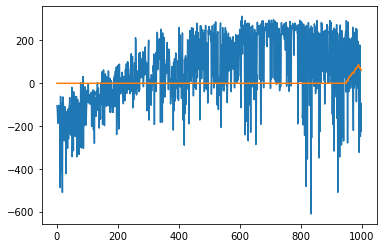

In [22]:
plt.plot(training_agent.rewards)
plt.plot(training_agent.moving_average)

[I 2022-06-12 22:01:46,357] A new study created in memory with name: no-name-eb36011f-f9de-44f6-b253-153428d9990a


The episode 1 total rewards is -257.92890228366923
The episode 11 total rewards is -127.07684855971345
The episode 21 total rewards is -391.1194038258198
The episode 31 total rewards is -228.0570674900716
The episode 41 total rewards is -122.43016885560566
The episode 51 total rewards is -386.9165278683204
The episode 61 total rewards is -319.44215308816035
The episode 71 total rewards is -35.42086237725613
The episode 81 total rewards is -109.6761235353246
The episode 91 total rewards is -60.87882010940865
The episode 101 total rewards is -219.23740342917264
The episode 111 total rewards is -74.3909092674826
The episode 121 total rewards is -5.705532270335283
The episode 131 total rewards is -165.1297574612692
The episode 141 total rewards is -76.22493373043018
The episode 151 total rewards is -174.16627508462122
The episode 161 total rewards is 72.42279704375073
The episode 171 total rewards is 49.64904718470949
The episode 181 total rewards is 21.113414967814382
The episode 191 tota

[I 2022-06-12 22:06:39,331] Trial 0 finished with value: -29.99549182288824 and parameters: {'DQL_nodes 1': 48, 'nodes_2': 45, 'dicount rate': 0.9783032937004372, 'lr': 0.000502586256733191, 'DQL nodes 2': 54, 'decay': 0.9933602260587918}. Best is trial 0 with value: -29.99549182288824.


The episode 1 total rewards is -242.14047645391224
The episode 11 total rewards is -96.02134826642487
The episode 21 total rewards is -131.1083963397374
The episode 31 total rewards is -157.3766723407089
The episode 41 total rewards is -115.52319736649063
The episode 51 total rewards is -65.10516296320682
The episode 61 total rewards is -172.7050514325747
The episode 71 total rewards is -153.9633908748865
The episode 81 total rewards is -182.9481175723144
The episode 91 total rewards is -76.65861940230687
The episode 101 total rewards is -221.7798107130646
The episode 111 total rewards is -161.43506754646856
The episode 121 total rewards is 103.26753139923105
The episode 131 total rewards is -187.83480063108826
The episode 141 total rewards is 36.23032762683923
The episode 151 total rewards is -81.88513789875897
The episode 161 total rewards is -69.79033658340974
The episode 171 total rewards is -107.83392852973236
The episode 181 total rewards is -105.51990110700473
The episode 191 to

[I 2022-06-12 22:07:32,804] Trial 1 finished with value: -99.70520742207957 and parameters: {'DQL_nodes 1': 96, 'nodes_2': 66, 'dicount rate': 0.9370978791284981, 'lr': 0.0008819628347575319, 'DQL nodes 2': 63, 'decay': 0.9987200264772003}. Best is trial 0 with value: -29.99549182288824.


The episode 1 total rewards is -118.84076448612475
The episode 11 total rewards is -30.048832734759856
The episode 21 total rewards is -258.8910951021716
The episode 31 total rewards is -186.5633227500574
The episode 41 total rewards is -250.26277293500098
The episode 51 total rewards is -86.8366262312989
The episode 61 total rewards is -208.25239753950783
The episode 71 total rewards is -229.74307820321445
The episode 81 total rewards is -281.3417966583273
The episode 91 total rewards is -368.08375156922665
The episode 101 total rewards is -96.04442395055457
The episode 111 total rewards is -198.46926237759632
The episode 121 total rewards is 18.235874631674875
The episode 131 total rewards is 106.78825113498769
The episode 141 total rewards is -225.24364891518263
The episode 151 total rewards is 58.04676089535188
The episode 161 total rewards is -160.44947398759143
The episode 171 total rewards is -35.396639320536536
The episode 181 total rewards is 25.198656447466117
The episode 191

[I 2022-06-12 22:12:07,828] Trial 2 finished with value: -28.12598937440493 and parameters: {'DQL_nodes 1': 34, 'nodes_2': 33, 'dicount rate': 0.9010952121615743, 'lr': 0.0005776518285238604, 'DQL nodes 2': 51, 'decay': 0.9906050684717242}. Best is trial 2 with value: -28.12598937440493.


The episode 1 total rewards is -248.8812737353379
The episode 11 total rewards is -189.79354456877493
The episode 21 total rewards is -207.02021018726646
The episode 31 total rewards is -195.10764487751268
The episode 41 total rewards is -65.20316259323408
The episode 51 total rewards is -144.98490126812396
The episode 61 total rewards is -57.194373538407
The episode 71 total rewards is -157.4786779819663
The episode 81 total rewards is -98.48646157024288
The episode 91 total rewards is -183.56198402882205
The episode 101 total rewards is -20.67067075827923
The episode 111 total rewards is 38.63655428898477
The episode 121 total rewards is 11.008286642639263
The episode 131 total rewards is -63.875490497050016
The episode 141 total rewards is -161.06686235607526
The episode 151 total rewards is 100.63889555270663
The episode 161 total rewards is 54.37035189439922
The episode 171 total rewards is 73.05151962415488
The episode 181 total rewards is 6.022259402713544
The episode 191 total 

[I 2022-06-12 22:16:46,968] Trial 3 finished with value: 41.82946896658695 and parameters: {'DQL_nodes 1': 46, 'nodes_2': 96, 'dicount rate': 0.9915670677042686, 'lr': 0.0009074084589674853, 'DQL nodes 2': 58, 'decay': 0.9942005887509291}. Best is trial 3 with value: 41.82946896658695.


The episode 1 total rewards is -204.80913664701438
The episode 11 total rewards is -156.0009112389271
The episode 21 total rewards is -68.69661597354194
The episode 31 total rewards is -330.6442446490594
The episode 41 total rewards is -80.02039248577776
The episode 51 total rewards is -77.59155110811218
The episode 61 total rewards is -261.61180158355273
The episode 71 total rewards is -422.63440737608283
The episode 81 total rewards is -149.26567097268085
The episode 91 total rewards is -158.5186877959187
The episode 101 total rewards is -89.53279422752964
The episode 111 total rewards is -301.72743365334986
The episode 121 total rewards is -93.89360150577662
The episode 131 total rewards is -98.2125845983281
The episode 141 total rewards is -100.64548183750995
The episode 151 total rewards is -175.2854198530402
The episode 161 total rewards is -76.25362422147404
The episode 171 total rewards is -218.03460672798596
The episode 181 total rewards is -104.8834703841826
The episode 191 t

[I 2022-06-12 22:17:32,755] Trial 4 finished with value: -120.84191837912216 and parameters: {'DQL_nodes 1': 37, 'nodes_2': 35, 'dicount rate': 0.9610071961820451, 'lr': 0.0006602756754233055, 'DQL nodes 2': 62, 'decay': 0.9988539795818744}. Best is trial 3 with value: 41.82946896658695.


The episode 1 total rewards is -100.19262856899421
The episode 11 total rewards is -322.88827562829124
The episode 21 total rewards is -434.34617949033935
The episode 31 total rewards is -401.8855499655979
The episode 41 total rewards is -245.35393582898004
The episode 51 total rewards is -321.14167226379993
The episode 61 total rewards is -210.98478942494546
The episode 71 total rewards is -177.56486434779117
The episode 81 total rewards is -255.2868039110522
The episode 91 total rewards is -66.8370197805145
The episode 101 total rewards is -42.13134429334145
The episode 111 total rewards is -204.86416812002392
The episode 121 total rewards is -2.486425917965306
The episode 131 total rewards is -55.3265115941852
The episode 141 total rewards is -135.31584121611695
The episode 151 total rewards is -44.353394331780244
The episode 161 total rewards is -59.7140324540089
The episode 171 total rewards is 63.29405789725937
The episode 181 total rewards is -27.34164518187319
The episode 191 t

[I 2022-06-12 22:20:41,976] Trial 5 finished with value: -41.019745802296164 and parameters: {'DQL_nodes 1': 49, 'nodes_2': 79, 'dicount rate': 0.9572936847858522, 'lr': 0.0006565298716658261, 'DQL nodes 2': 32, 'decay': 0.9956080725479213}. Best is trial 3 with value: 41.82946896658695.


The episode 1 total rewards is -325.639409699011
The episode 11 total rewards is -346.54936249396303
The episode 21 total rewards is -134.62079112097672
The episode 31 total rewards is -33.04240742127993
The episode 41 total rewards is -270.21451488600894
The episode 51 total rewards is -178.0780565137514
The episode 61 total rewards is -179.5482366669986
The episode 71 total rewards is -195.18538591730908
The episode 81 total rewards is -104.67151049054483
The episode 91 total rewards is -62.79261311001281
The episode 101 total rewards is -104.74160340864799
The episode 111 total rewards is -53.19956528336384
The episode 121 total rewards is -82.94282307094386
The episode 131 total rewards is -51.14817011429786
The episode 141 total rewards is -148.31430421438736
The episode 151 total rewards is -93.89670250559861
The episode 161 total rewards is -65.82731059773099
The episode 171 total rewards is 20.019350262700172
The episode 181 total rewards is -83.32218472818609


KeyboardInterrupt: 

In [88]:
print(training_agent.agent.eps)
training_agent.test_agent(env,render=True)


0.05
The episode total rewards is  199.85354865513972
